EDA AND PREPROCESSING

In [4]:
import pandas as pd
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.model_selection import train_test_split
from imblearn.over_sampling import SMOTE

# Load the dataset
df = pd.read_csv('cybersecurity_intrusion_data.csv')


In [6]:
#Droping non informative column
df.drop('session_id', axis=1, inplace=True)


In [8]:
print(df.head())

   network_packet_size protocol_type  login_attempts  session_duration  \
0                  599           TCP               4        492.983263   
1                  472           TCP               3       1557.996461   
2                  629           TCP               3         75.044262   
3                  804           UDP               4        601.248835   
4                  453           TCP               5        532.540888   

  encryption_used  ip_reputation_score  failed_logins browser_type  \
0             DES             0.606818              1         Edge   
1             DES             0.301569              0      Firefox   
2             DES             0.739164              2       Chrome   
3             DES             0.123267              0      Unknown   
4             AES             0.054874              1      Firefox   

   unusual_time_access  attack_detected  
0                    0                1  
1                    0                0  
2       

In [37]:
# Identify categorical features
categorical_features = ['protocol_type', 'encryption_used', 'browser_type']

# Apply one-hot encoding
df_encoded = pd.get_dummies(df, columns=categorical_features, drop_first=True)


In [39]:
# Numeric features to scale
numeric_features = ['network_packet_size', 'login_attempts', 'session_duration',
                    'ip_reputation_score', 'failed_logins']

# Standard scaling
scaler = StandardScaler()
df_encoded[numeric_features] = scaler.fit_transform(df_encoded[numeric_features])


Split Dataset into Training and Test Sets

In [42]:
X = df_encoded.drop('attack_detected', axis=1)
y = df_encoded['attack_detected']

# Train-test split (70-30)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.3, random_state=42, stratify=y
)


In [44]:
# Using SMOTE for balancing training data
smote = SMOTE(random_state=42)
X_train_balanced, y_train_balanced = smote.fit_resample(X_train, y_train)


In [46]:
print("Shape of original training data:", X_train.shape)
print("Shape after SMOTE balancing:", X_train_balanced.shape)

print("\nClass distribution before SMOTE:\n", y_train.value_counts())
print("\nClass distribution after SMOTE:\n", y_train_balanced.value_counts())


Shape of original training data: (6675, 13)
Shape after SMOTE balancing: (7382, 13)

Class distribution before SMOTE:
 attack_detected
0    3691
1    2984
Name: count, dtype: int64

Class distribution after SMOTE:
 attack_detected
1    3691
0    3691
Name: count, dtype: int64


Now for Modeling

In [49]:
#Importing relevant libraries
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, roc_auc_score, classification_report


In [51]:
# Define classifiers
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(use_label_encoder=False, eval_metric='logloss', random_state=42)
}

# Dictionary to store results
results = {}

# Train and evaluate models
for model_name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    predictions = model.predict(X_test)
    probabilities = model.predict_proba(X_test)[:, 1]

    results[model_name] = {
        'Accuracy': accuracy_score(y_test, predictions),
        'Precision': precision_score(y_test, predictions),
        'Recall': recall_score(y_test, predictions),
        'F1-score': f1_score(y_test, predictions),
        'ROC-AUC': roc_auc_score(y_test, probabilities)
    }

# Display results
results_df = pd.DataFrame(results).T
print(results_df)


                     Accuracy  Precision    Recall  F1-score   ROC-AUC
Logistic Regression  0.717680   0.675857  0.708594  0.691838  0.788846
Random Forest        0.880503   0.978571  0.749219  0.848673  0.876332
XGBoost              0.873864   0.949169  0.758594  0.843248  0.876653


C:\Users\Robin\anaconda3\Lib\site-packages\xgboost\training.py:183: UserWarning: [17:17:49] WARNING: C:\actions-runner\_work\xgboost\xgboost\src\learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


In [53]:
from sklearn.model_selection import GridSearchCV

# Parameter grid for Random Forest
param_grid = {
    'n_estimators': [100, 200],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

# GridSearchCV setup
grid_search = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid,
    cv=5,
    scoring='f1',
    verbose=2,
    n_jobs=-1
)

# Fit on balanced training data
grid_search.fit(X_train_balanced, y_train_balanced)

# Best hyperparameters
print("Best parameters found:", grid_search.best_params_)

# Evaluate tuned model
best_rf = grid_search.best_estimator_
predictions_tuned = best_rf.predict(X_test)

# Tuned model evaluation
print(classification_report(y_test, predictions_tuned))


Fitting 5 folds for each of 18 candidates, totalling 90 fits
Best parameters found: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      1582
           1       0.98      0.75      0.85      1280

    accuracy                           0.88      2862
   macro avg       0.91      0.87      0.88      2862
weighted avg       0.90      0.88      0.88      2862



Recommended Hyperparamter training. 

In [60]:
param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20, 30],
    'min_samples_split': [2, 5, 10]
}


In [62]:
param_grid_xgb = {
    'n_estimators': [100, 200],
    'max_depth': [3, 6, 10],
    'learning_rate': [0.01, 0.1, 0.2]
}


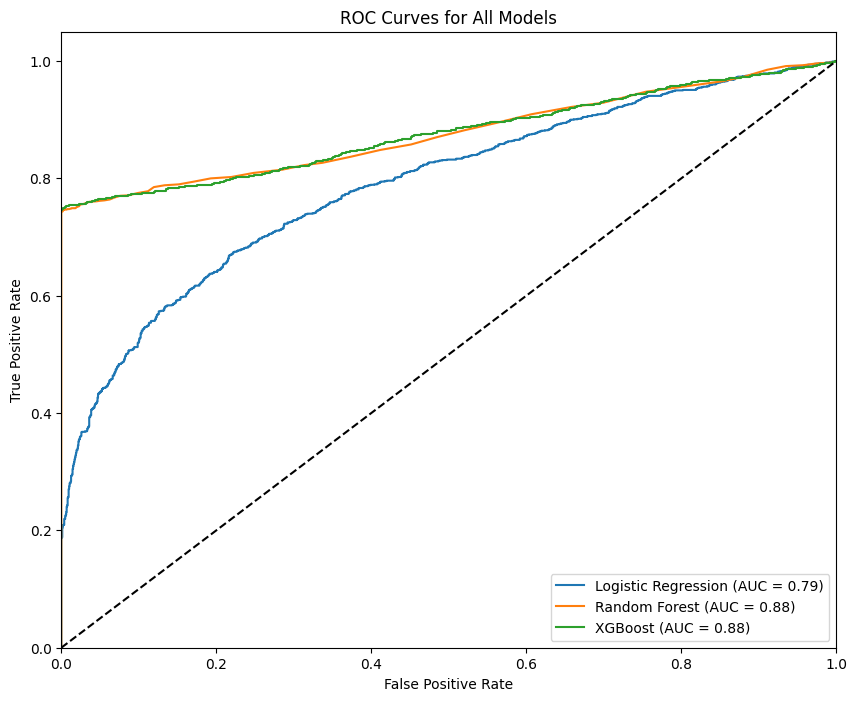

In [64]:
import matplotlib.pyplot as plt
from sklearn.metrics import roc_curve, auc

models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, random_state=42),
    'Random Forest': RandomForestClassifier(n_estimators=100, random_state=42),
    'XGBoost': XGBClassifier(eval_metric='logloss', random_state=42)
}

plt.figure(figsize=(10, 8))

for name, model in models.items():
    model.fit(X_train_balanced, y_train_balanced)
    probabilities = model.predict_proba(X_test)[:, 1]
    fpr, tpr, _ = roc_curve(y_test, probabilities)
    roc_auc = auc(fpr, tpr)
    plt.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

plt.plot([0, 1], [0, 1], 'k--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curves for All Models')
plt.legend(loc='lower right')
plt.show()


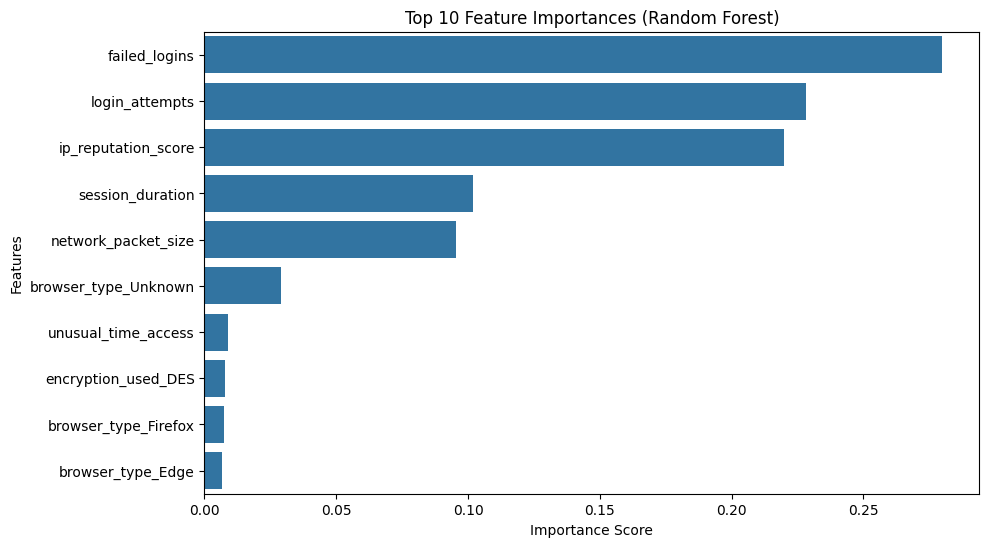

In [66]:
import seaborn as sns

rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train_balanced, y_train_balanced)

feature_importances = pd.Series(rf_model.feature_importances_, index=X_train_balanced.columns)
feature_importances = feature_importances.sort_values(ascending=False)[:10]

plt.figure(figsize=(10,6))
sns.barplot(x=feature_importances, y=feature_importances.index)
plt.title('Top 10 Feature Importances (Random Forest)')
plt.xlabel('Importance Score')
plt.ylabel('Features')
plt.show()


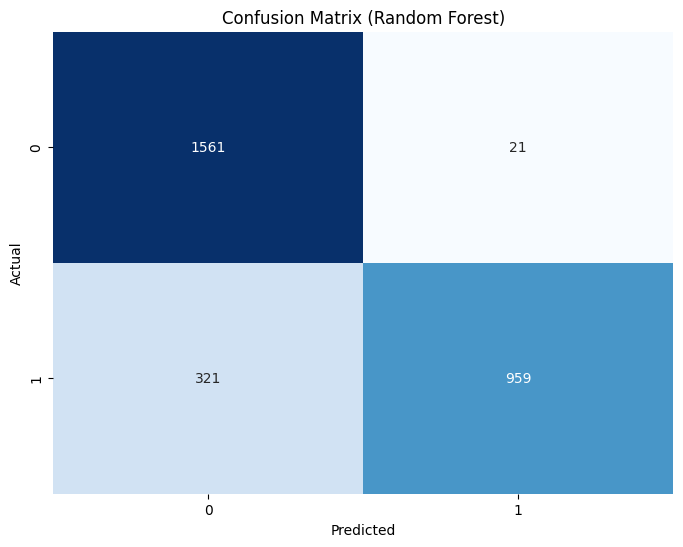

In [68]:
from sklearn.metrics import confusion_matrix
import seaborn as sns

best_model = rf_model  # Assuming Random Forest was best
y_pred = best_model.predict(X_test)

cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='g', cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix (Random Forest)')
plt.show()


In [70]:
from sklearn.model_selection import GridSearchCV

param_grid_rf = {
    'n_estimators': [100, 200, 300],
    'max_depth': [None, 10, 20],
    'min_samples_split': [2, 5, 10]
}

grid_search_rf = GridSearchCV(
    estimator=RandomForestClassifier(random_state=42),
    param_grid=param_grid_rf,
    scoring='f1',
    cv=5,
    n_jobs=-1,
    verbose=2
)

# Fit GridSearchCV
grid_search_rf.fit(X_train_balanced, y_train_balanced)

# Display Best Parameters
print("Best Parameters:", grid_search_rf.best_params_)

# Evaluate optimized model
rf_best = grid_search_rf.best_estimator_
y_pred_optimized = rf_best.predict(X_test)

# Optimized model results
print(classification_report(y_test, y_pred_optimized))


Fitting 5 folds for each of 27 candidates, totalling 135 fits
Best Parameters: {'max_depth': None, 'min_samples_split': 2, 'n_estimators': 200}
              precision    recall  f1-score   support

           0       0.83      0.99      0.90      1582
           1       0.98      0.75      0.85      1280

    accuracy                           0.88      2862
   macro avg       0.91      0.87      0.88      2862
weighted avg       0.90      0.88      0.88      2862



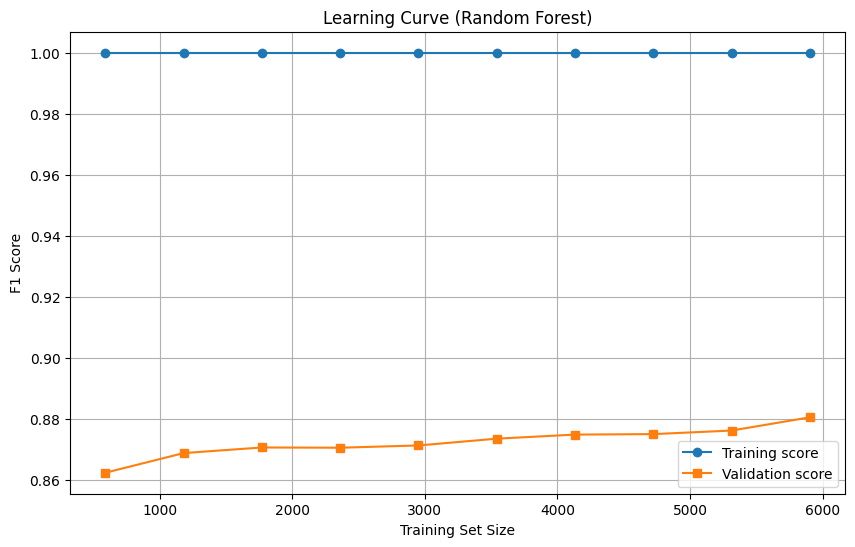

In [72]:
from sklearn.model_selection import learning_curve
import numpy as np

train_sizes, train_scores, test_scores = learning_curve(
    RandomForestClassifier(random_state=42),
    X_train_balanced, y_train_balanced, 
    cv=5, scoring='f1', n_jobs=-1,
    train_sizes=np.linspace(0.1, 1.0, 10)
)

train_mean = np.mean(train_scores, axis=1)
test_mean = np.mean(test_scores, axis=1)

plt.figure(figsize=(10, 6))
plt.plot(train_sizes, train_mean, label='Training score', marker='o')
plt.plot(train_sizes, test_mean, label='Validation score', marker='s')
plt.xlabel('Training Set Size')
plt.ylabel('F1 Score')
plt.title('Learning Curve (Random Forest)')
plt.legend()
plt.grid()
plt.show()


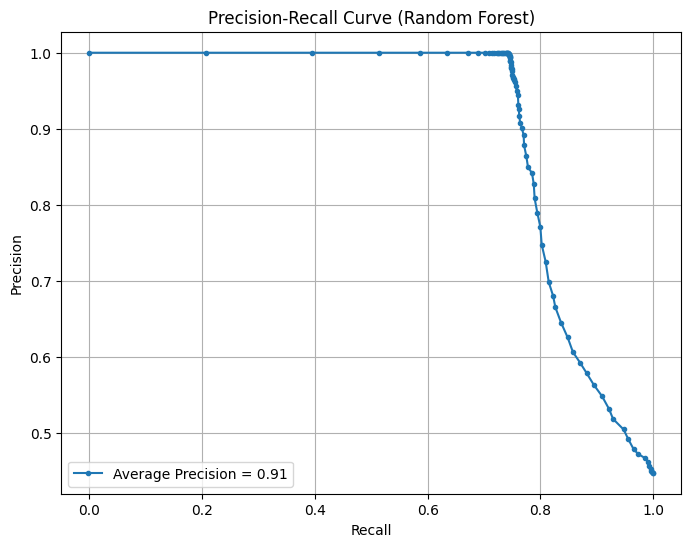

In [44]:
from sklearn.metrics import precision_recall_curve, average_precision_score

model = RandomForestClassifier(random_state=42)
model.fit(X_train_balanced, y_train_balanced)
probs = model.predict_proba(X_test)[:, 1]

precision, recall, thresholds = precision_recall_curve(y_test, probs)
average_precision = average_precision_score(y_test, probs)

plt.figure(figsize=(8, 6))
plt.plot(recall, precision, marker='.', label=f'Average Precision = {average_precision:.2f}')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve (Random Forest)')
plt.legend()
plt.grid()
plt.show()


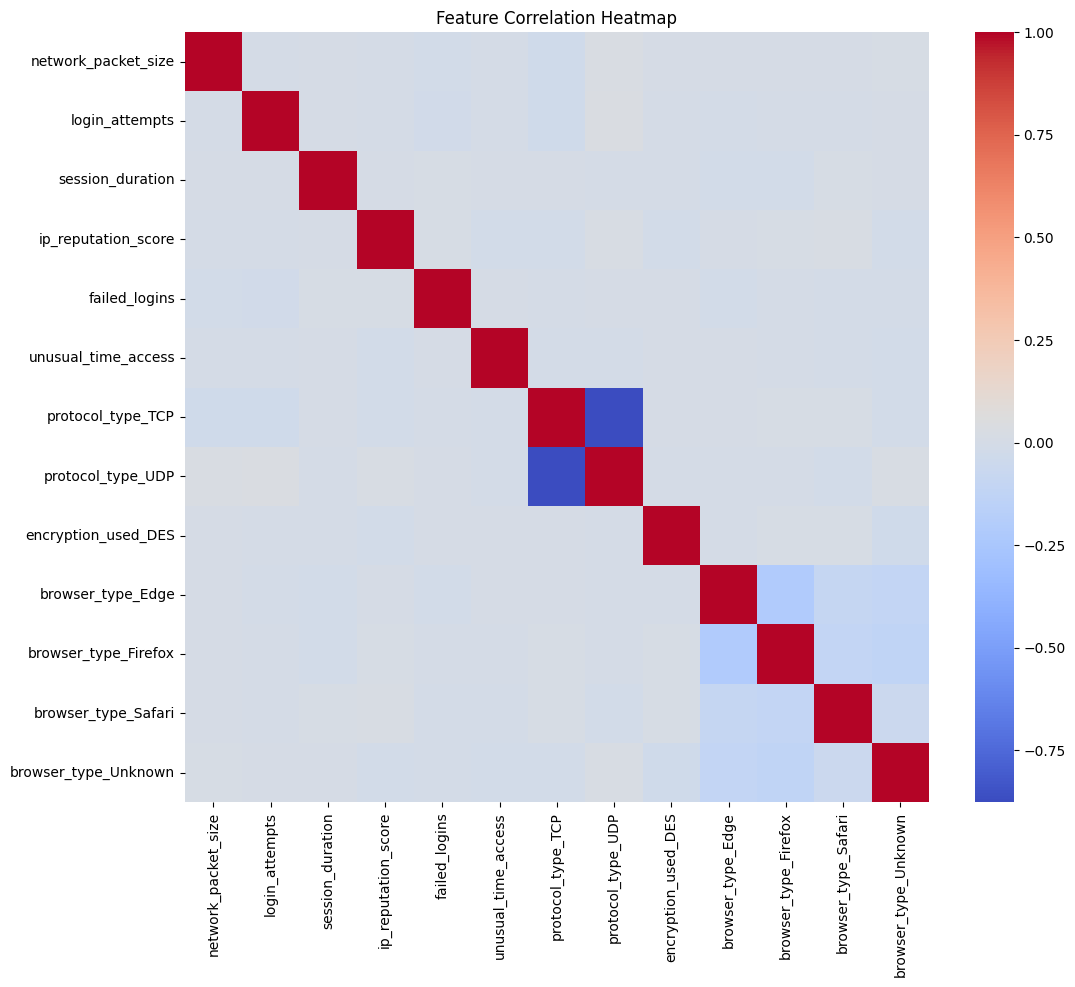

In [74]:
plt.figure(figsize=(12,10))
sns.heatmap(X_train_balanced.corr(), cmap='coolwarm', annot=False)
plt.title('Feature Correlation Heatmap')
plt.show()


Text(0.5, 1.0, 'Top 10 Feature Importances - Random Forest')

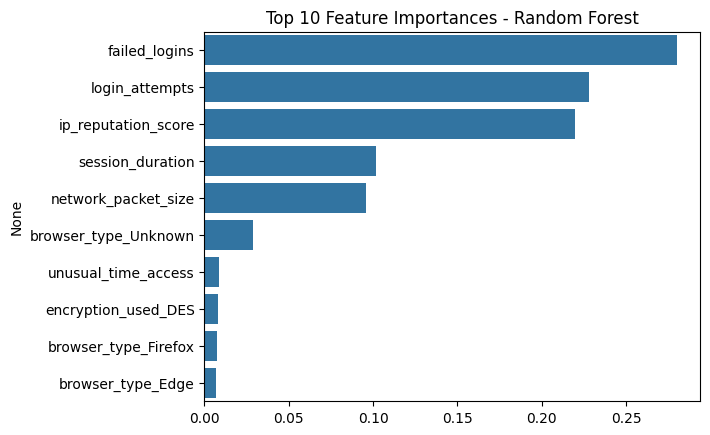

In [78]:
import seaborn as sns

feat_imp = pd.Series(rf_model.feature_importances_, index=X.columns)
top_feat = feat_imp.sort_values(ascending=False).head(10)

sns.barplot(x=top_feat.values, y=top_feat.index)
plt.title("Top 10 Feature Importances - Random Forest")
